In [11]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv("./Heart_dataset.csv")

Text(0.5, 1.0, 'Sex')

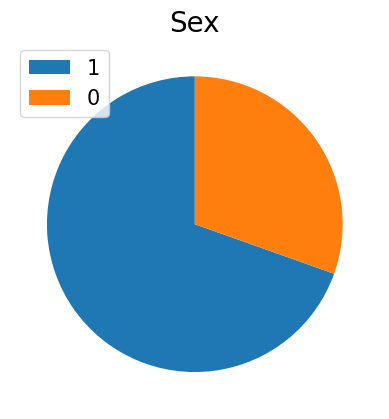

In [13]:
import matplotlib.pyplot as plt

counts = df["sex"].value_counts()
labels = counts.index

# Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2, fontsize=15)
plt.title("Sex", size=20)

In [14]:
age_threshold = df["age"].median()
age_threshold

56.0

In [15]:
df["age_binary"] = np.where(df["age"] > age_threshold, 1, 0)

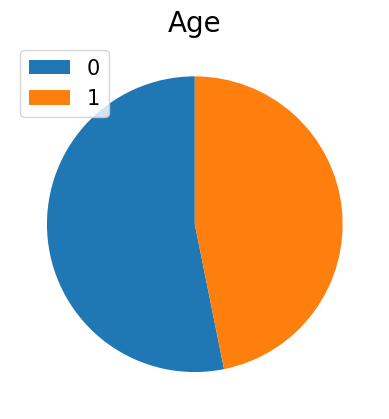

In [16]:
# Get population count by age
counts = df["age_binary"].value_counts()
labels = counts.index

# Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2, fontsize=15)
plt.title("Age", size=20)
plt.show()

In [17]:
unprivileged_groups = [{"sex": 0}]
privileged_groups = [{"sex": 1}]

In [18]:
#  BinaryLabelDataset DataFrame
target_variable = "target"
dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=[target_variable],
    protected_attribute_names=["sex", "age_binary"],
)

In [19]:
metric_orig = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

In [20]:
print("Original dataset metrics:")
print(f"Disparate Impact: {metric_orig.disparate_impact()}")
print(f"Mean Difference: {metric_orig.mean_difference()}")

Original dataset metrics:
Disparate Impact: 1.721559829059829
Mean Difference: 0.3036016111051174


In [21]:
# Use the Reweighing algorithm to mitigate bias
RW = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
dataset_transf = RW.fit_transform(dataset)

In [22]:
from aif360.metrics import BinaryLabelDatasetMetric

# Compute fairness metrics
metric_transf = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

print("Transformed dataset metrics:")
print(f"Disparate Impact: {metric_transf.disparate_impact()}")
print(f"Mean Difference: {metric_transf.mean_difference()}")

Transformed dataset metrics:
Disparate Impact: 1.0
Mean Difference: 0.0


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold

In [24]:
# Split the transformed dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    dataset_transf.features,
    dataset_transf.labels.ravel(),
    test_size=0.2,
    random_state=0,
)

In [25]:
decision_tree_model = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=5)
gradient_boosting_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1
)

In [26]:
voting_classifier = VotingClassifier(
    estimators=[
        ("decision_tree", decision_tree_model),
        ("random_forest", random_forest_model),
        ("gradient_boosting", gradient_boosting_model),
    ],
    voting="hard",
)

In [27]:
clf = voting_classifier.fit(X_train, y_train)

In [28]:
y_pred = clf.predict(X_test)

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


In [30]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95        98
         1.0       0.93      0.99      0.96       107

    accuracy                           0.96       205
   macro avg       0.96      0.95      0.96       205
weighted avg       0.96      0.96      0.96       205



In [31]:
# test the model on sample test data
sample_data = X_test[:5]
sample_labels = y_test[:5]
sample_pred = clf.predict(sample_data)

print("\nSample Predictions:")
for i, (sample, label, pred) in enumerate(zip(sample_data, sample_labels, sample_pred)):
    print(f"Sample {i + 1}:")
    print(f"  Features: {sample}")
    print(f"  Label: {label}")
    print(f"  Prediction: {pred}")
    print()


Sample Predictions:
Sample 1:
  Features: [ 44.    1.    2.  130.  233.    0.    1.  179.    1.    0.4   2.    0.
   2.    0. ]
  Label: 1.0
  Prediction: 1.0

Sample 2:
  Features: [ 58.   0.   1. 136. 319.   1.   0. 152.   0.   0.   2.   2.   2.   1.]
  Label: 0.0
  Prediction: 1.0

Sample 3:
  Features: [ 63.   1.   0. 140. 187.   0.   0. 144.   1.   4.   2.   2.   3.   1.]
  Label: 0.0
  Prediction: 0.0

Sample 4:
  Features: [ 58.   1.   2. 140. 211.   1.   0. 165.   0.   0.   2.   0.   2.   1.]
  Label: 1.0
  Prediction: 1.0

Sample 5:
  Features: [ 61.    1.    0.  120.  260.    0.    1.  140.    1.    3.6   1.    1.
   3.    1. ]
  Label: 0.0
  Prediction: 0.0



In [32]:
dataset_transf

               instance weights features                                    \
                                         protected attribute                 
                                     age                 sex   cp trestbps   
instance names                                                               
0                      0.840458     52.0                 1.0  0.0    125.0   
1                      0.840458     53.0                 1.0  0.0    140.0   
2                      0.840458     70.0                 1.0  0.0    145.0   
3                      0.840458     61.0                 1.0  0.0    148.0   
4                      1.766171     62.0                 0.0  0.0    138.0   
...                         ...      ...                 ...  ...      ...   
1020                   1.219636     59.0                 1.0  1.0    140.0   
1021                   0.840458     60.0                 1.0  0.0    125.0   
1022                   0.840458     47.0                 1.0  0.